In [1]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-02-20 20:41:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  11.9MB/s    in 26s     

2024-02-20 20:41:45 (6.74 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-02-20 20:41:45--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  15.6MB/s    in 4.5s    

2024-02-20 20:41:50 (13.7 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [3]:
trainset = loadmat("train_32x32.mat")
testset = loadmat("test_32x32.mat")

In [4]:
trainset['X'].shape, testset['X'].shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

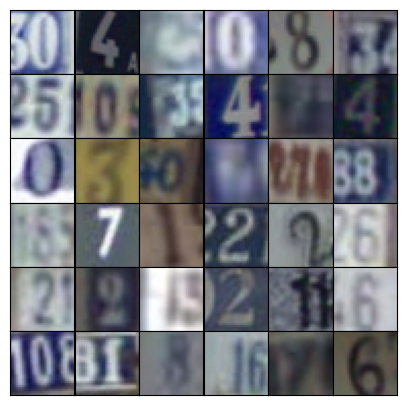

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for i, ax in zip(idx, axes.flatten()):
  ax.imshow(trainset['X'][:, :, :, i], aspect='equal')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [82]:
def scale(x, feature_range=(-1, 1)):
  x = (x - tf.reduce_min(x))/(255 - tf.reduce_min(x))

  min, max = feature_range
  x = x * (max - min) + min
  return x

In [83]:
buffer_size = 70000
BATCH_SIZE = 256
train_dataset = tf.transpose(trainset['X'], (3, 0, 1, 2))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.map(map_func=scale, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(BATCH_SIZE)

In [84]:
imgs = next(iter(train_dataset))
imgs.shape

TensorShape([256, 32, 32, 3])

In [89]:
imgs[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-0.7975708 , -0.77327937, -0.82186234],
        [-0.77327937, -0.74898785, -0.7975708 ],
        [-0.7651822 , -0.74898785, -0.7975708 ],
        ...,
        [-0.82186234, -0.87854254, -0.805668  ],
        [-0.757085  , -0.805668  , -0.74898785],
        [-0.6923077 , -0.7408907 , -0.7246964 ]],

       [[-0.7651822 , -0.7004049 , -0.7975708 ],
        [-0.7165992 , -0.659919  , -0.77327937],
        [-0.6923077 , -0.65182185, -0.7651822 ],
        ...,
        [-0.81376517, -0.8704454 , -0.8299595 ],
        [-0.757085  , -0.805668  , -0.78947365],
        [-0.70850205, -0.74898785, -0.77327937]],

       [[-0.7246964 , -0.6680162 , -0.7651822 ],
        [-0.659919  , -0.61943316, -0.7327935 ],
        [-0.611336  , -0.5951417 , -0.7246964 ],
        ...,
        [-0.82186234, -0.8623482 , -0.854251  ],
        [-0.7651822 , -0.805668  , -0.82186234],
        [-0.7165992 , -0.74898785, -0.78947365]],

       ...,

       

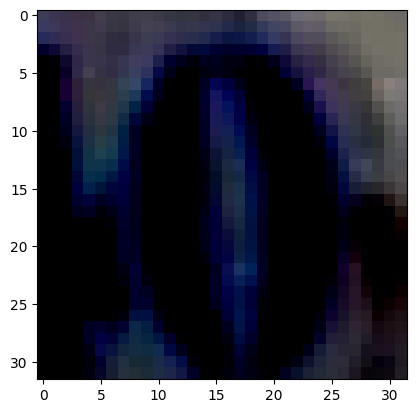

In [85]:
import random
index = random.randint(0, imgs.shape[0]-1)
plt.imshow(imgs[index])

In [90]:
def build_generator_seq():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(4 * 4 * 512, input_shape=(100, ), use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((4, 4, 512)))

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  print(model.output_shape)

  model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same"))
  model.add(tf.keras.layers.Activation('tanh'))

  print(model.output_shape)

  return model

def build_generator_func():
  inputs = tf.keras.layers.Input(shape=(100,))
  x = tf.keras.layers.Dense(4*4*512)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Reshape((4, 4, 512))(x)

  x = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=True)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)



  outputs = tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2, 2), padding='same')(x)
  model = tf.keras.Model(inputs, outputs)
  print(model.output_shape)
  return model


In [91]:
generator = build_generator_seq()
generator.summary()

(None, 4, 4, 512)
(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 32, 32, 3)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8192)              819200    
                                                                 
 batch_normalization_33 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_11 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_32 (Conv2  (None, 8, 8, 256)         3276800   
 DTranspose)                                                     
                                              

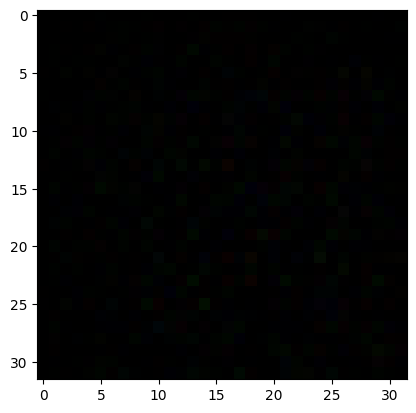

In [92]:
noise = tf.random.normal((1, 100))
img = generator(noise, training=False)
plt.imshow(tf.squeeze(img), cmap='gray')

In [93]:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(256, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

In [96]:
discriminator = build_discriminator()
decision = discriminator(img)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49999648]], dtype=float32)>

In [98]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimzier = tf.keras.optimizers.Adam(1e-4)